Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/452M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/452M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/7488 [00:00<?, ? examples/s]

Map:   0%|          | 0/1802 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,0.389700,0.517211,0.808546
2,0.318000,0.508256,0.845727
3,0.290200,0.466150,0.847947
4,0.245500,0.521781,0.851276
5,0.204700,0.511997,0.860155
6,0.179900,0.519315,0.865150
7,0.171400,0.540468,0.866815
8,0.177600,0.587284,0.866260
9,0.101800,0.617559,0.863485
10,0.127300,0.587721,0.867925


성능 보고서:
              precision    recall  f1-score   support

     class_0       0.91      0.77      0.84       901
     class_1       0.80      0.92      0.86       901

    accuracy                           0.85      1802
   macro avg       0.86      0.85      0.85      1802
weighted avg       0.86      0.85      0.85      1802



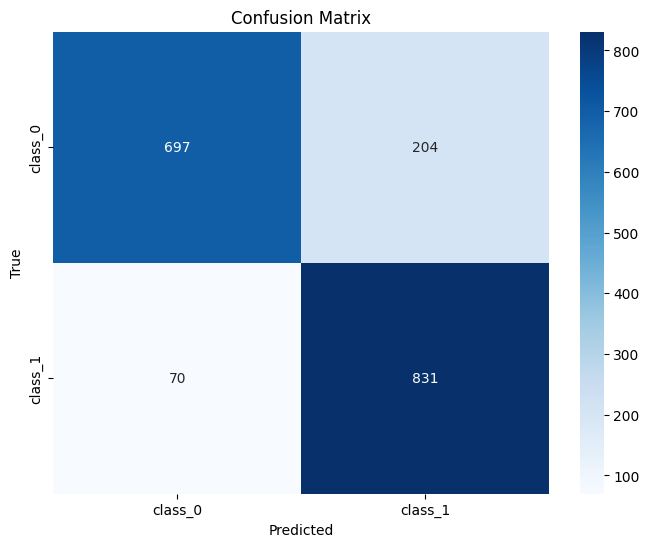

In [1]:
from google.colab import drive #코랩에서 할 때
drive.mount('/content/drive')

!pip install datasets #코랩에서 할 때

from transformers import (
    Trainer, TrainingArguments,
    ElectraTokenizer,
    ElectraConfig,
    ElectraForSequenceClassification)
from datasets import Dataset
from sklearn.utils import *
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd

#허깅페이스에서 KoELECTRA 가져오기 + KoELECTRA 모델 설정
config = ElectraConfig.from_pretrained("monologg/koelectra-base-v3-discriminator",
                                       num_labels=2,
                                       attention_probs_dropout_prob=0.3,
                                       hidden_dropout_prob=0.3)
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator", config=config)
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

train_df = pd.read_csv("/content/drive/MyDrive/combined_reviews2 - train.csv", encoding="utf-8")
test_df = pd.read_csv("/content/drive/MyDrive/combined_reviews2 - test.csv", encoding="utf-8")

# 데이터 불균형 해결 (예: 소수 클래스 오버샘플링)
train_df_minority = train_df[train_df['라벨링'] == 1]  # 소수 클래스 예시
train_df_majority = train_df[train_df['라벨링'] == 0]  # 다수 클래스 예시

# 소수 클래스 오버샘플링
train_df_minority_upsampled = resample(
    train_df_minority,
    replace=True,
    n_samples=len(train_df_majority),
    random_state=123
)

# 새로운 훈련 데이터 생성
train_df_balanced = pd.concat([train_df_majority, train_df_minority_upsampled])

# Dataset 객체로 변환
train_data = Dataset.from_pandas(train_df_balanced[['전처리된 트윗', '라벨링']])
test_data = Dataset.from_pandas(test_df[['전처리된 트윗', '라벨링']])

# 전처리된 트윗 열을 이용해 토큰화
def tokenize_function(examples):
    return tokenizer(examples['전처리된 트윗'], padding='max_length', truncation=True)

train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

# 라벨 이름을 'labels'로 변환
train_data = train_data.rename_column("라벨링", "labels")
test_data = test_data.rename_column("라벨링", "labels")

# 키워드 정의
keywords = ['제품 제공', '광고', '#제품제공', '#광고', '#타채널제품제공',
            '협찬', "'쿠팡, 파트너'", '제품제공', '#제품지원', '쿠팡파트너',
            '#대가성광고',"'제품', '제공'"]

# 손실 가중치 계산 함수
def compute_class_weights(dataset):
    labels = dataset['labels']  # labels 열 가져오기
    total = len(labels)
    class_0_count = sum(1 for label in labels if label == 0)  # 0 클래스 카운트
    class_1_count = sum(1 for label in labels if label == 1)  # 1 클래스 카운트

    weight_for_0 = total / class_0_count
    weight_for_1 = total / class_1_count

    return torch.tensor([weight_for_0, weight_for_1], dtype=torch.float)

# 손실 가중치 적용
class_weights = compute_class_weights(train_data)

torch.cuda.empty_cache() #GPU 오류 해결 관련 코드

for param in model.parameters():
    param.data = param.data.contiguous() #GPU 오류 해결 관련 코드

# 훈련 인자 설정
training_args = TrainingArguments(
    no_cuda = False,
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10, #에포크 변경
    weight_decay=0.01,
    report_to="none",
    load_best_model_at_end=True,  # 가장 좋은 모델 로드
    metric_for_best_model='eval_loss',  # 성능 지표로 사용할 것
    greater_is_better=False,  # 낮은 값이 더 좋은 경우
    logging_steps=50,
    adam_epsilon=1e-8,
    warmup_steps=500,
)
device = "cuda:0" if torch.cuda.is_available() else "cpu" #GPU 오류 해결 관련 코드


# compute_metrics 함수 수정: 손실 가중치 적용4
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=-1)

    # 키워드가 있는 경우 무조건 0으로 예측
    adjusted_preds = []
    for idx, tweet in enumerate(test_data["전처리된 트윗"]):
        if any(keyword in tweet for keyword in keywords):
            adjusted_preds.append(0)
        else:
            adjusted_preds.append(preds[idx].item())

    accuracy = accuracy_score(labels, adjusted_preds)
    return {"accuracy": accuracy}

# Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics,
)

# 모델 학습
trainer.train()

# 모델 저장 (원하는 경로에 저장)
trainer.save_model("/content/drive/MyDrive/koELECTRA_1")

# 테스트 데이터에 대해 예측 수행
def predict_with_keywords(examples):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 모델과 동일한 장치 설정
    model.to(device)  # 모델을 해당 장치로 이동

    predictions = []
    for tweet in examples["전처리된 트윗"]:
        if any(keyword in tweet for keyword in keywords):
            predictions.append(0)  # 키워드가 포함된 경우 무조건 0으로 예측
        else:
            # 모델을 사용한 예측
            inputs = tokenizer(tweet, return_tensors='pt', padding=True, truncation=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}  # 입력 텐서를 모델과 동일한 디바이스로 이동
            outputs = model(**inputs)
            predictions.append(outputs.logits.argmax(dim=1).item())  # 예측된 라벨 추가

    return predictions

test_predictions = predict_with_keywords(test_df)
test_df['예측'] = test_predictions

# 성능 평가 출력
print("성능 보고서:")
report = classification_report(test_df['라벨링'], test_df['예측'], target_names=['class_0', 'class_1'])
print(report)

# 혼동 행렬 시각화
cm = confusion_matrix(test_df['라벨링'], test_df['예측'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['class_0', 'class_1'], yticklabels=['class_0', 'class_1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()